In [0]:
import pandas as pd
import math
import os

In [80]:
import keras
keras.__version__

'2.2.4'

In [0]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

In [0]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CSCI_89_Final_Project/mafia_with_splits.csv')

In [0]:
df['new_label'] = df.category.apply (lambda x: 1 if x=='Mafia' else 0)

In [0]:
texts = list(df['title'])

In [0]:
labels = list(df['new_label'])

In [88]:
texts[0:5]

['i thought you were just town reading him and arent you scumreading me someone being your counterwagon is a terrible reason to vote them',
 'unless i messed up horribly somewhere with my calcumalationzzim shit at math dont judge im pretty sure this is not an automatic win for town',
 'this of course contradicts a few things i have said in the past at first glance so i want to clear up my feelings right now before you guys get it in your head im contradicting myself',
 'this post set off some bells i think it seems like a bit of an overreaction but at this point i cant decide if its kneejerk omgus or just overly explaining your vote logic i do agree that robbs post was lazy but then again theres not enough content to really go into detail',
 'this is the second time youve ignored my question should i or should i not lynch somebody that i think is town if the only alternative is no lynch']

In [89]:
labels[0:5]

[1, 0, 1, 1, 0]

In [104]:
df['split'].value_counts()

train    524132
val      131033
test      72797
Name: split, dtype: int64

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [105]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = df['split'].value_counts()[0] 
validation_samples = df['split'].value_counts()[1] 
test_samples = df['split'].value_counts()[2]
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[validation_samples: validation_samples + test_samples]
y_test = labels[validation_samples: validation_samples + test_samples]

Found 160094 unique tokens.
Shape of data tensor: (727962, 100)
Shape of label tensor: (727962,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [110]:
glove_dir = '/content/drive/My Drive/Colab Notebooks/CSCI_89_Final_Project/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [113]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,098,165
Trainable params: 1,098,165
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [115]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=1,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 524132 samples, validate on 131033 samples
Epoch 1/1
524132/524132 [==============================] - 1084s 2ms/step - loss: 0.5395 - acc: 0.7703 - val_loss: 0.5404 - val_acc: 0.7700


Let's plot its performance over time:

## Only 1 epoch. I plotted T-SNE of the LSTM layer. It shows a lot of overlap because of only 1 epoch, it should show more separation if more epochs are run.

In [0]:
def create_truncated_model(trained_model):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(100))
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

truncated_model = create_truncated_model(model)
# hidden_features = truncated_model.predict(x_test)

In [117]:
truncated_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               66000     
Total params: 1,098,064
Trainable params: 1,098,064
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_features = truncated_model.predict(x_test)

In [119]:
hidden_features.shape

(72797, 100)

In [120]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.9926974664231532
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.002429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.548912
[t-SNE] KL divergence after 1000 iterations: 1.023406


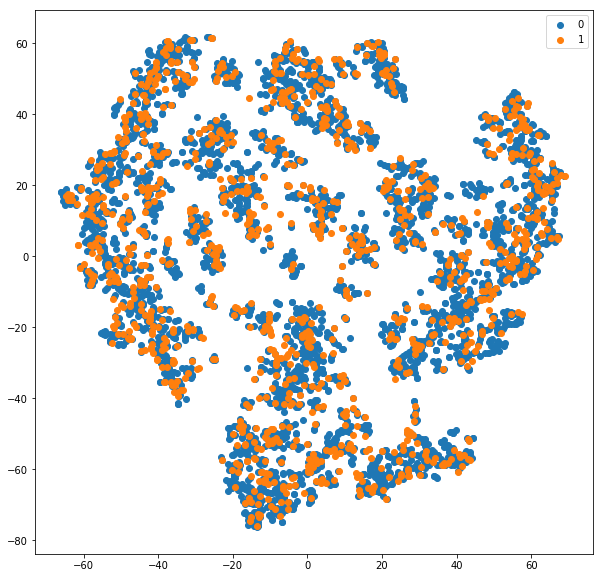

In [121]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(y_test[:5000], num_classes = 2)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()

## Ran the same model but unfroze the embeddings, so they train with the model. Plot of "embedding drift", compares the original Glove embeddings with the trained embeddings.

In [122]:
# same model no freezing of embedding
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

e_model = Sequential()
e_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
e_model.add(Dropout(0.2))
e_model.add(Conv1D(64, 5, activation='relu'))
e_model.add(MaxPooling1D(pool_size=4))
e_model.add(LSTM(100))
e_model.add(Dense(1, activation='sigmoid'))
e_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 1,098,165
Trainable params: 1,098,165
Non-trainable params: 0
_________________________________________________________________


In [123]:
e_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = e_model.fit(x_train, y_train,
                    epochs=1,
                    batch_size=32,
                    validation_data=(x_val, y_val))
e_model.save_weights('no_freeze_trained_glove_model.h5')

Train on 524132 samples, validate on 131033 samples
Epoch 1/1
524132/524132 [==============================] - 1121s 2ms/step - loss: 0.5395 - acc: 0.7704 - val_loss: 0.5395 - val_acc: 0.7700


## Function to compare embeddings

In [0]:
def get_compare_embeddings(original_embeddings, tuned_embeddings, vocab, dimreduce_type="pca", random_state=0):
    """ Compare embeddings drift. """
    if dimreduce_type == "pca":
        from sklearn.decomposition import PCA
        dimreducer = PCA(n_components=2, random_state=random_state)
    elif dimreduce_type == "tsne":
        from sklearn.manifold import TSNE
        dimreducer = TSNE(n_components=2, random_state=random_state)
    else:
        raise Exception("Wrong dimreduce_type.")

    reduced_original = dimreducer.fit_transform(original_embeddings)
    reduced_tuned = dimreducer.fit_transform(tuned_embeddings)

    def compare_embeddings(word):
        if word not in vocab:
            return None
        word_id = vocab[word]
        original_x, original_y = reduced_original[word_id, :]
        tuned_x, tuned_y = reduced_tuned[word_id, :]
        return original_x, original_y, tuned_x, tuned_y

    return compare_embeddings

In [0]:
embeddings = model.get_weights()[0]
e_embeddings = e_model.get_weights()[0]

In [143]:
compare_embeddings = get_compare_embeddings(embeddings, e_embeddings, word_index, dimreduce_type="pca", random_state=0)
print("Embeddings drift:", compare_embeddings('brothers'))
print("Embeddings drift:", compare_embeddings('scum'))
print("Embeddings drift:", compare_embeddings('misconception'))
print("Embeddings drift:", compare_embeddings('rules'))
print("Embeddings drift:", compare_embeddings('liar'))

Embeddings drift: (1.4193034, 1.7353332, 0.013413417, -0.18485121)
Embeddings drift: (-1.7448215, 0.11545214, 0.3562664, 0.15893348)
Embeddings drift: (-1.2439103, -1.5282469, 0.077454485, -0.11008301)
Embeddings drift: (2.4075308, -0.77480656, -0.27455512, -0.17741533)
Embeddings drift: (-1.0999182, -0.376359, 0.45825237, 0.29862276)


In [0]:
word_list = ['brothers', 'scum', 'misconception', 'rules', 'liar', 'reasons', 'night', 'wrong', 'suspicious', 'claimed', 'possible', 'argument', 'understand', 'points', 'pressure', 'please']

## Plot of embedding comparison for selected words

In [0]:
x = []
y = []
new_wl = [] 
for wl in word_list:
  temp = compare_embeddings(wl)
  x.append(temp[0])
  x.append(temp[2]*3)
  y.append(temp[1])
  y.append(temp[3]*3)
  new_wl.append(wl)
  new_wl.append(wl)

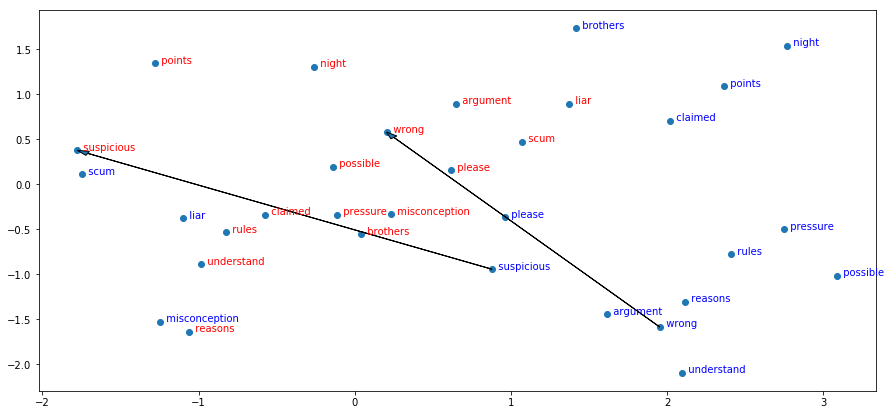

In [213]:
def drawArrow(A, B):
  plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1], head_width=0.05, length_includes_head=True)

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(x, y)

for i, txt in enumerate(new_wl):
  if i % 2 == 0:
    ax.annotate('  ' + txt, (x[i], y[i]), color='blue')
  else:
    ax.annotate('  ' + txt, (x[i], y[i]), color='red')
    
drawArrow((x[14],y[14]), (x[15],y[15]))
drawArrow((x[16],y[16]), (x[17],y[17]))


In [138]:
word_index.items()

Output hidden; open in https://colab.research.google.com to view.